# COMP24111 - Exercise 3: _Face recognition_

## 1. Task description

You will work on a face recognition task. The provided dataset includes face images of 40 subjects. There are a total of 400 images, with 10 images per subject. Each image contains 32×32=1024 pixels, with 256 grey levels per pixel.

## 2. Preparation

### Setting up

The functions that you need are defined in the source file we have provided you with. To use them you must import it first:

In [1]:
from lab3lib import load_data, show_single_face, show_faces, partition_data, split_left_right, join_left_right, show_split_faces

Now you can load the data:

In [2]:
data, labels = load_data()

### Visualising the dataset

You can observe the faces stored in a data matrix by using the functions `show_single_face()` and `show_faces()`.

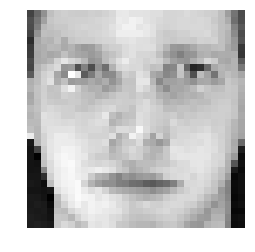

In [3]:
# Display a single example.
show_single_face(data[0, :])

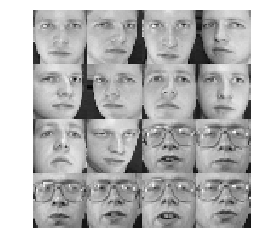

In [4]:
# Display the first 16 examples in a 4x4 grid.
show_faces(data[:16, :], num_per_row=4)

### Splitting into train and test set

A data partition function is supplied to facilitate your experiments. It randomly splits the provided data into the training and test sets, where the training set contains $N$ samples per class and the test set contains
the remaining samples. It takes the labels and the specified number $N$ as the input. It returns the sample indices in the training and test set. For example, the following code divides a given set of 400 samples into a training set containing 3 samples per subject and a test set containing 7 samples per subject:

In [5]:
tr_ind, te_ind = partition_data(labels, num_per_class=3)
tr_data = data[tr_ind, :]
tr_label = labels[tr_ind]
te_data = data[te_ind, :]
te_label = labels[te_ind]

## 3. $L_2$-regularised least squares implementation

Now, you will need to implement the function `l2_rls_train` below. It should train a linear model by minimising the $L_2$-regularised sum of squares loss using the normal equations (this is called $L_2$*-regularised least squares model*, or *ridge regression model*). It should support both single-output and multi-output cases. This function should take a set of training samples and a user-specified regularisation parameter $\lambda$ as the input, and return the predicted weights.

In [6]:
def l2_rls_train(tr_data, tr_labels, hyperparameter):
    """
    Training based on a given hyperparameter, where the formula
    used to find the weighting is dictated by the hyperparameter.

    tr_data: training data
    tr_labels: training labels

    Returns: the weighting for the given class
    """
    
    # This is just to be consistent with the lecture notes.
    X, y = tr_data, tr_labels
    
    # Expand X with a column of ones.
    column_of_ones = np.ones((X.shape[0],1))
    X_tilde = np.concatenate((column_of_ones,X), axis = 1)
    
    # Compute the coefficient vector.
    if(hyperparameter == 0):
        w = np.linalg.pinv(X_tilde) @ y
    else:
        identity_matrix = np.eye(X_tilde.shape[1])
        inside_val = X_tilde.T @ X_tilde + (hyperparameter * identity_matrix)
        w = (np.linalg.inv(inside_val) @ X_tilde.T) @ y

    # Return model parameters.
    return w

Once you have trained your model, you can use it on to predict new data. Implement the following function to do this.

In [7]:
def l2_rls_predict(w, data):
    """
    Uses the weighting and the data to predict new data

    w: weighting found using the above training model
    data: the new data that needs to be classified

    Returns: the predicted class for the given data
    """
    
    # This is just to be consistent with the lecture notes.
    X = data
    
    # Begin by initialising a column of ones that can then be multiplied by the weighting
    column_of_ones = np.ones((X.shape[0],1))
    X_tilde = np.concatenate((column_of_ones,X), axis = 1)
    predicted_y = X_tilde @ w
    
    return predicted_y

## 4. Experiments

Start to use your functions `l2_rls_train` and `l2_rls_predict` to perform the following experiments.

### Experiment 1: Binary Classification

Start with a binary classification task to classify face images for subjects “1” and “30”.

Train three classifiers:
1. Set $y=-1$ for samples from “1” and $y=+1$ for samples from “30” to train a linear model, and use the threshold $T= 0$ to obtain the class prediction.
2. Set $y=0$ for samples from “1” and $y=1$ for samples from “30” to train a linear model, and use the threshold $T= 0.5$ to obtain the class prediction.
2. Set $y=1$ for samples from “1” and $y=30$ for samples from “30” to train a linear model, and use the threshold $T= 15.5$ to obtain the class prediction.

Randomly select 3 images per subject for training, and use the remaining images for testing. Train your classifier 1 and test it with a fixed regularisation parameter $\lambda$=0. Repeat this process 50 times and record the training and test errors.

In [8]:
def exp1(label_class_1, label_class_30):
    # Partition the data, with 3 samples being used for training with the other 7 making up the testing set
    tr_ind_all, te_ind_all = partition_data(labels, num_per_class = 3)
    
    # Select the indices for subjects 1 and 30
    tr_ind = np.concatenate((tr_ind_all[:3], tr_ind_all[29*3:30*3]), axis = None)
    te_ind = np.concatenate((te_ind_all[:7], te_ind_all[29*7:30*7]), axis = None)
    
    # Map the labels and partition the data
    tr_data = data[tr_ind, :]
    tr_labels = np.concatenate((np.full(3, label_class_1), np.full(3, label_class_30)), axis = None)
    te_data = data[te_ind, :]
    te_labels = np.concatenate((np.full(7, label_class_1), np.full(7, label_class_30)), axis = None)

    
    # Train your model to find the weights
    w = l2_rls_train(tr_data, tr_labels, 0)
    
    # Define the threshold
    T = (label_class_1 + label_class_30) / 2
    
    # Perform prediction for training 
    training_prediction = l2_rls_predict(w, tr_data)
    
    # Loop through the training predictions and see what class they fall into based on the threshold
    for i in range(0, training_prediction.size):
        if(training_prediction[i] < T):
            training_prediction[i] = label_class_1
        else:
            training_prediction[i] = label_class_30
    
    # Compute the training error
    tr_err_counter = 0
    for i in range(0, training_prediction.size):
        if(training_prediction[i] != tr_labels[i]):
            tr_err_counter = tr_err_counter + 1
    
    tr_err = tr_err_counter/training_prediction.size
    
    # Perform prediction for testing
    testing_prediction = l2_rls_predict(w, te_data)
    
    # Loop through the training predictions and see what class they fall into based on the threshold
    for i in range(0, testing_prediction.size):
        if(testing_prediction[i] < T):
            testing_prediction[i] = label_class_1
        else:
            testing_prediction[i] = label_class_30
            
    # Compute the test error
    te_err_counter = 0
    for i in range(0, testing_prediction.size):
        if(testing_prediction[i] != te_labels[i]):
            te_err_counter = te_err_counter + 1
    
    te_err = te_err_counter/testing_prediction.size
    
    # Return the training and test errors
    return tr_err, te_err

In [9]:
# Use the `exp1()` function to experiment with classifier 1.
import numpy as np
# Array to store the test and training errors for classifier 1
classifier1_tr_err = np.empty(50)
classifier1_te_err = np.empty(50)

# Repeat the experiment 50 times
for i in range (50):
    tr_err, te_err = exp1(-1, 1)
    print(i + 1, ":")
    print("  Training error = ", tr_err * 100, "%")
    print("  Testing error  = ", te_err * 100, "%")
    classifier1_tr_err[i] = tr_err
    classifier1_te_err[i] = te_err
    
# Compute and display the mean testing error for this experiment
print("Mean testing error:")
classifier1_te_err_mean = np.mean(classifier1_te_err) * 100
print("  ", classifier1_te_err_mean, "%")



1 :
  Training error =  0.0 %
  Testing error  =  14.285714285714285 %
2 :
  Training error =  0.0 %
  Testing error  =  14.285714285714285 %
3 :
  Training error =  0.0 %
  Testing error  =  21.428571428571427 %
4 :
  Training error =  0.0 %
  Testing error  =  7.142857142857142 %
5 :
  Training error =  0.0 %
  Testing error  =  0.0 %
6 :
  Training error =  0.0 %
  Testing error  =  0.0 %
7 :
  Training error =  0.0 %
  Testing error  =  0.0 %
8 :
  Training error =  0.0 %
  Testing error  =  7.142857142857142 %
9 :
  Training error =  0.0 %
  Testing error  =  0.0 %
10 :
  Training error =  0.0 %
  Testing error  =  0.0 %
11 :
  Training error =  0.0 %
  Testing error  =  21.428571428571427 %
12 :
  Training error =  0.0 %
  Testing error  =  14.285714285714285 %
13 :
  Training error =  0.0 %
  Testing error  =  0.0 %
14 :
  Training error =  0.0 %
  Testing error  =  0.0 %
15 :
  Training error =  0.0 %
  Testing error  =  14.285714285714285 %
16 :
  Training error =  0.0 %
  Tes

Repeat the same experiment for classifier 2.

In [10]:
# Use the `exp1()` function to experiment with classifier 2.

# Array to store the test errors for classifier 2
classifier2_te_err = np.empty(50)

# Repeat the experiment 50 times
for i in range (50):
    tr_err, te_err = exp1(0, 1)
    print(i + 1, ":")
    print("  Training error = ", tr_err * 100, "%")
    print("  Testing error  = ", te_err * 100, "%")
    classifier2_te_err[i] = te_err

# Compute and display the mean testing error for this experiment
print("Mean testing error:")
classifier2_te_err_mean = np.mean(classifier2_te_err) * 100
print("  ", classifier2_te_err_mean, "%")


1 :
  Training error =  0.0 %
  Testing error  =  0.0 %
2 :
  Training error =  0.0 %
  Testing error  =  7.142857142857142 %
3 :
  Training error =  0.0 %
  Testing error  =  7.142857142857142 %
4 :
  Training error =  0.0 %
  Testing error  =  0.0 %
5 :
  Training error =  0.0 %
  Testing error  =  14.285714285714285 %
6 :
  Training error =  0.0 %
  Testing error  =  0.0 %
7 :
  Training error =  0.0 %
  Testing error  =  0.0 %
8 :
  Training error =  0.0 %
  Testing error  =  7.142857142857142 %
9 :
  Training error =  0.0 %
  Testing error  =  14.285714285714285 %
10 :
  Training error =  0.0 %
  Testing error  =  7.142857142857142 %
11 :
  Training error =  0.0 %
  Testing error  =  21.428571428571427 %
12 :
  Training error =  0.0 %
  Testing error  =  14.285714285714285 %
13 :
  Training error =  0.0 %
  Testing error  =  0.0 %
14 :
  Training error =  0.0 %
  Testing error  =  0.0 %
15 :
  Training error =  0.0 %
  Testing error  =  0.0 %
16 :
  Training error =  0.0 %
  Testi

Repeat the same experiment for classifier 3.

In [11]:
# Use the `exp1()` function to experiment with classifier 3.

# Array to store the test errors for classifier 3
classifier3_te_err = np.empty(50)

# Repeat the experiment 50 times
for i in range (50):
    tr_err, te_err = exp1(1, 30)
    print(i + 1, ":")
    print("  Training error = ", tr_err * 100, "%")
    print("  Testing error  = ", te_err * 100, "%")
    classifier3_te_err[i] = te_err

# Compute and display the mean testing error for this experiment
print("Mean testing error:")
classifier3_te_err_mean = np.mean(classifier3_te_err) * 100  
print("  ", classifier3_te_err_mean, "%")


1 :
  Training error =  0.0 %
  Testing error  =  28.57142857142857 %
2 :
  Training error =  0.0 %
  Testing error  =  0.0 %
3 :
  Training error =  0.0 %
  Testing error  =  14.285714285714285 %
4 :
  Training error =  0.0 %
  Testing error  =  21.428571428571427 %
5 :
  Training error =  0.0 %
  Testing error  =  0.0 %
6 :
  Training error =  0.0 %
  Testing error  =  7.142857142857142 %
7 :
  Training error =  0.0 %
  Testing error  =  0.0 %
8 :
  Training error =  0.0 %
  Testing error  =  14.285714285714285 %
9 :
  Training error =  0.0 %
  Testing error  =  0.0 %
10 :
  Training error =  0.0 %
  Testing error  =  0.0 %
11 :
  Training error =  0.0 %
  Testing error  =  21.428571428571427 %
12 :
  Training error =  0.0 %
  Testing error  =  0.0 %
13 :
  Training error =  0.0 %
  Testing error  =  7.142857142857142 %
14 :
  Training error =  0.0 %
  Testing error  =  7.142857142857142 %
15 :
  Training error =  0.0 %
  Testing error  =  7.142857142857142 %
16 :
  Training error = 

Print the test error mean and standard deviation of the three classifiers and display them in the same plot.

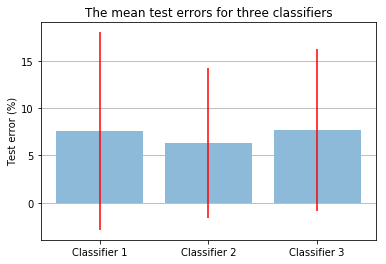

In [12]:
# Find the test error mean for each classifier (as a percentage)
classifier1_te_err_mean = np.mean(classifier1_te_err) * 100
classifier2_te_err_mean = np.mean(classifier2_te_err) * 100
classifier3_te_err_mean = np.mean(classifier3_te_err) * 100

# Find the standard deviation for each classifier (as a percentage)
classifier1_te_err_std = np.std(classifier1_te_err) * 100
classifier2_te_err_std = np.std(classifier2_te_err) * 100
classifier3_te_err_std = np.std(classifier3_te_err) * 100

# Create the graph
from matplotlib import pyplot as plt
classifiers = ['Classifier 1', 'Classifier 2', 'Classifier 3']
classifier_means = [classifier1_te_err_mean, classifier2_te_err_mean, classifier3_te_err_mean]
classifier_stds = [classifier1_te_err_std, classifier2_te_err_std, classifier3_te_err_std]
graph, axis = plt.subplots()
axis.bar(np.arange(len(classifiers)), classifier_means, yerr = classifier_stds, align = 'center', alpha = 0.5, ecolor = 'red')
axis.set_title('The mean test errors for three classifiers')
axis.set_xticks(np.arange(len(classifiers)))
axis.set_xticklabels(classifiers)
axis.set_ylabel('Test error (%)')
axis.yaxis.grid(True)

Compare the three classifiers and comment on your results.

What training accuracies do you obtain with your linear classifier? Explain the reason.

Between subjects “1” and “30”, which one is more difficult for the linear classifier to recognise? Explain it.

### Experiment 2: Multi-class Classification

Now, proceed to the multi-class classification task to classify face images for all the 40 subjects. Decide an appropriate way to set your target output and make class prediction. 

Split your data to two sets: the training set contains 5 randomly selected images per subject and the test set contains the remaining images. The training set is used to train the model and select hyper-parameter $\lambda$, while the test set is only for final assessment of the trained classifier with the selected $\lambda$. 

Design an appropriate and complete machine learning experiment, which should include the training, hyper-parameter selection and evaluation stages. You can choose from the random subsampling, $k$-fold CV and LOO approaches for hyper-parameter selection. 

Write your code below and make sure it compiles. Show your code to the TA, explain your classifier and experiment design.

In [13]:
# Initialise an array to store the errors for each subject
subject_err_array = np.zeros((40))

def hyperparameter_selection(tr_ind, val_ind, training_data, training_labels):
    """
    Finds the best value for lambda using some method of hyperparameter selection.
    """
    # Map the labels and the data as before
    tr_data = training_data[tr_ind]
    tr_labels = training_labels[tr_ind]
    val_data = training_data[val_ind]
    val_labels = training_labels[val_ind]
    
    # Initiate the hyperparameter as 0 to start to increment later
    hyperparameter = 0
    err_array = np.array([])
    
    # Test for 250 hyperparameters
    for i in range(250):
        # Training labels for each subject
        matrix_tr_labels = np.zeros((tr_labels.shape[0],40))
        for j in range(matrix_tr_labels.shape[0]):
            matrix_tr_labels[j, tr_labels[j] - 1] = 1
            
        # Train the model
        w = l2_rls_train(tr_data, matrix_tr_labels, hyperparameter)
        
        # Predict based on the validation data
        val_prediction = l2_rls_predict(w, val_data)
        val_prediction_values = np.argmax(val_prediction, axis = 1) + 1
        
        #Find the number of errors for each prediction (as well as for each subject)
        val_err = 0
        for j in range(val_prediction_values.shape[0]):
            if(val_prediction_values[j] != val_labels[j]):
                val_err = val_err + 1
                subject_err_array[val_labels[j] - 1] = subject_err_array[val_labels[j] - 1] + 1
                
        # Store this information in the error array
        err_array = np.append(err_array, (val_err / val_prediction_values.shape[0]))
        
        #Increment the hyperparameter
        hyperparameter = hyperparameter + 4000
        
        #Display the hyperparameter and the corresponding error rate
        print("Lambda : ", str(hyperparameter), " has an error rate of ", str(val_err / val_prediction_values.shape[0]))
        
    # Find the lowest error rate and therefore the best lambda
    best_lambda = (np.argmin(err_array) + 1) * 4000
    
    # Return the best value for lambda as well as the error array
    return best_lambda, err_array

In [14]:
# Partition the data to get the training and test indices
tr_ind_all, te_ind_all = partition_data(labels, num_per_class = 5)

# Find the training labels and data from these indices 
tr_labels = labels[tr_ind_all]
tr_data = data[tr_ind_all]

# Partition the data again to get the validtion indices
tr_ind, val_ind = partition_data(tr_labels, num_per_class = 3)

# Use the above function to find the best value for the hyperparameter
best_lambda, err_array = hyperparameter_selection(tr_ind, val_ind, tr_data, tr_labels)

#Display the best hyperparameter
print("Best hyperparameter (lambda) :" + str(best_lambda))

Lambda :  4000  has an error rate of  0.0625
Lambda :  8000  has an error rate of  0.0625
Lambda :  12000  has an error rate of  0.0625
Lambda :  16000  has an error rate of  0.0625
Lambda :  20000  has an error rate of  0.0625
Lambda :  24000  has an error rate of  0.0625
Lambda :  28000  has an error rate of  0.0625
Lambda :  32000  has an error rate of  0.0625
Lambda :  36000  has an error rate of  0.0625
Lambda :  40000  has an error rate of  0.0625
Lambda :  44000  has an error rate of  0.0625
Lambda :  48000  has an error rate of  0.0625
Lambda :  52000  has an error rate of  0.0625
Lambda :  56000  has an error rate of  0.0625
Lambda :  60000  has an error rate of  0.0625
Lambda :  64000  has an error rate of  0.0625
Lambda :  68000  has an error rate of  0.0625
Lambda :  72000  has an error rate of  0.0625
Lambda :  76000  has an error rate of  0.0625
Lambda :  80000  has an error rate of  0.0625
Lambda :  84000  has an error rate of  0.0625
Lambda :  88000  has an error rate o

Lambda :  712000  has an error rate of  0.0625
Lambda :  716000  has an error rate of  0.0625
Lambda :  720000  has an error rate of  0.0625
Lambda :  724000  has an error rate of  0.0625
Lambda :  728000  has an error rate of  0.0625
Lambda :  732000  has an error rate of  0.0625
Lambda :  736000  has an error rate of  0.0625
Lambda :  740000  has an error rate of  0.0625
Lambda :  744000  has an error rate of  0.0625
Lambda :  748000  has an error rate of  0.0625
Lambda :  752000  has an error rate of  0.0625
Lambda :  756000  has an error rate of  0.0625
Lambda :  760000  has an error rate of  0.0625
Lambda :  764000  has an error rate of  0.0625
Lambda :  768000  has an error rate of  0.0625
Lambda :  772000  has an error rate of  0.0625
Lambda :  776000  has an error rate of  0.0625
Lambda :  780000  has an error rate of  0.0625
Lambda :  784000  has an error rate of  0.0625
Lambda :  788000  has an error rate of  0.0625
Lambda :  792000  has an error rate of  0.0625
Lambda :  796

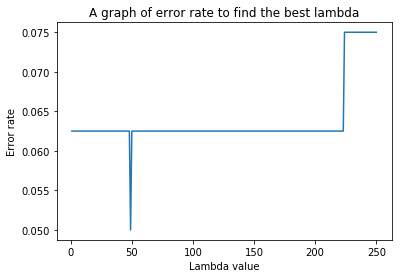

In [15]:
from matplotlib import pyplot as plt

# Plot a graph of the error rate for each lambda value
plt.errorbar(np.arange(1,251), err_array)
plt.xlabel('Lambda value')
plt.ylabel('Error rate')
plt.title('A graph of error rate to find the best lambda')
plt.show()

Analyse the classification results, and pick some subjects that are considered the most difficult to recognise by your classifier. Show and explain it to the TA.

The hardest subjects to classify are:  [19  5  7 13]


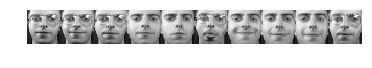

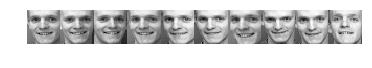

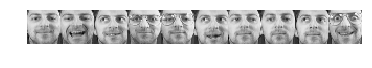

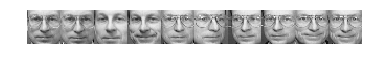

In [16]:
# The faces with the most errors appear here
# Most will be of subjects that have images from obscur angles as seen below
difficult_subject_array = subject_err_array.argsort()[-4:][::-1] + 1
print("The hardest subjects to classify are: ", str(difficult_subject_array))

for i in difficult_subject_array:
    show_faces(data[np.argwhere(labels == (i))[:, 0]], num_per_row = 10)

### Experiment 3: Face Completion

Revise the “Regression Example II” on face completion in Chapter 2. The task is to guess the 512 pixels of the right face from the 512 pixels of the left face. 

The following command can be used to extract the left and right faces from the input data.

In [17]:
left, right = split_left_right(data)

And you can visualise them with the function `show_split_faces()`:

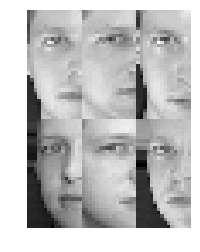

In [18]:
show_split_faces(left[:6, :], num_per_row=3)

Build a face completion model using your functions `l2_rls_train` and `l2_rls_predict`. Design an experiment to assess your model, which should include appropriate training and testing. Use mean absolute percentage error to evaluate the regression performance. You do not need to bother with hyper-parameter selection, but simply set $\lambda$=0.

Write your code below and make sure it compiles. Show your code to the TA, explain your model and experiment design, and demonstrate results.

In [19]:
# Partition the data into training and testing
tr_indices, te_indices = partition_data(labels, num_per_class = 5)

# Extract the training and testing data
tr_data = data[tr_ind]
te_data = data[te_ind]

# Split this data into the left and right half of the face for each subject
tr_left, tr_right = split_left_right(tr_data)
te_left, te_right = split_left_right(te_data)

# Train using the training data to find the weighting
w = l2_rls_train(tr_left, tr_right, 0)

# Use this to make a prediction of the face
prediction = l2_rls_predict(w, te_left)

# Find and display the MAPE
mean_absolute_percentage_err = np.sum(np.abs((te_right - prediction) / te_right)) * 100 / te_right.size
print("Mean absolute percentage error: ", mean_absolute_percentage_err)



Mean absolute percentage error:  18.063251816605614


Visualise and compare the ground truth face (include both the left and right parts) and the completed face (include both the true left and predicted right parts) for 3 randomly chosen testing samples below. You can use `join_left_right(left, right)` to concatenate the left and right halves of a set of faces.

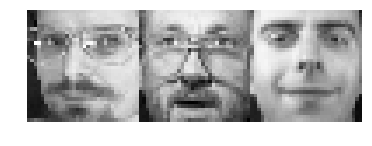

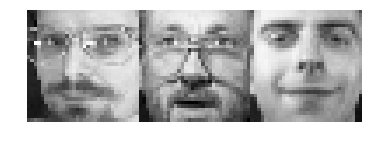

In [20]:
# Randomly select 3 faces
random_ind = np.random.choice(200, 3)

#Create the prediction for the face
predicted_face = join_left_right(te_left, prediction)

#Display the actual and then predicted faces
show_faces(te_data[random_ind], num_per_row = 3)
show_faces(predicted_face[random_ind], num_per_row = 3)

Does your model work well? Comment on it.

## 5. Deliverables and Marking

By the deadline, you should submit one single Jupyter file using GitLab. Please find the coursework submission instruction from the following link: https://wiki.cs.manchester.ac.uk/index.php/UGHandbook19:Coursework .

This exercise is worth 15 marks – marks will be allocated roughly on the basis of: 
- rigorous experimentation,
- knowledge displayed when talking to the TA,
- problem solving skill,
- self-learning ability,
- how informative and well presented your graphs are,
- language and ease of reading.

You must be able to explain any code you've written in order to get full marks. During the marking session we will ask you to run all cells in your Jupyter file, so ensure that the file is runnable using the "Restart Kernel and Run All Cells" menu option.

The lab is marked out of 15:

|                          |         |
|:------------------------ |--------:|
| $L_2$-RLS Implementation | 3 marks |
| Experiment 1             | 4 marks |
| Experiment 2             | 4 marks |
| Experiment 3             | 4 marks |